In [1]:
import os
from typing import Any, Optional, Union
import matplotlib
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Kwargs = dict[str, Any]
MetricType = Union[bool, Kwargs]


_METRIC_TYPE = "Metric Type"
_AGGREGATE_SCORE = ["Accuracy", "Macro F1"] 




def plot_results_table(df, show: bool = True, save_path: Optional[str] = None
    ) -> Table:
        """Plot the benchmarking results.

        Parameters
        ----------
        min_max_scale
            Whether to min max scale the results.
        show
            Whether to show the plot.
        save_dir
            The directory to save the plot to. If `None`, the plot is not saved.
        """
        
        
        # Do not want to plot what kind of metric it is
        plot_df = df.drop(_METRIC_TYPE, axis=0)
        num_embeds = plot_df.shape[0]
        # Sort by total score
        # plot_df = plot_df.sort_values(by=_AGGREGATE_SCORE, ascending=False).astype(np.float64)
        plot_df["Dataset"] = plot_df.index

        # Split columns by metric type, using df as it doesn't have the new method col
        other_cols = df.columns[df.loc[_METRIC_TYPE].isin(_AGGREGATE_SCORE)]
        print(other_cols)
        column_definitions = [
            ColumnDefinition("Dataset", width=1.5, textprops={"ha": "left", "weight": "bold"}),
        ]
        # Circles for the metric values
        # for i in other_cols:
        #     print(i)
        #     print(plot_df[i].isna())
        #     print(cmap_fn(plot_df[i].values))
        cmap = LinearSegmentedColormap.from_list(
        name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
        )
        column_definitions += [
            ColumnDefinition(
            name=col,
            title=col.split('.')[0],
            formatter="{:.2f}",
            cmap=cmap,
            group=df.loc[_METRIC_TYPE, col],
            )
            # ColumnDefinition(
            #     col,
            #     title=col.split('.')[0],
            #     width=1,
            #     textprops={
            #         "ha": "center",
            #         "bbox": {"boxstyle": "circle", "pad": 0.25},
            #     },
            #     cmap=matplotlib.cm.PRGn,
            #     group=df.loc[_METRIC_TYPE, col],
            #     formatter="{:.2f}",
            # )
            for i, col in enumerate(other_cols)
        ]
        # Bars for the aggregate scores
        # column_definitions += [
        #     ColumnDefinition(
        #         col,
        #         width=1,
        #         title=col.split('.')[0],
        #         plot_fn=bar,
        #         plot_kw={
        #             "cmap": matplotlib.cm.YlGnBu,
        #             "plot_bg_bar": False,
        #             "annotate": True,
        #             "height": 0.9,
        #             "formatter": "{:.2f}",
        #         },
        #         group=df.loc[_METRIC_TYPE, col],
        #         border="left" if i == 0 else None,
        #     )
        #     for i, col in enumerate(score_cols)
        # ]
        # Allow to manipulate text post-hoc (in illustrator)
        with matplotlib.rc_context({"svg.fonttype": "none"}):
            fig, ax = plt.subplots(figsize=(len(df.columns) * 1.3, 3 + 0.35 * num_embeds))
            ax.patch.set_facecolor("white")
            tab = Table(
                plot_df,
                cell_kw={
                    "linewidth": 0,
                    "edgecolor": "k",
                },
                column_definitions=column_definitions,
                ax=ax,
                row_dividers=True,
                footer_divider=True,
                textprops={"fontsize": 10, "ha": "center"},
                row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
                col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
                column_border_kw={"linewidth": 1, "linestyle": "-"},
                index_col="Dataset",
            ).autoset_fontcolors(colnames=plot_df.columns)
        if show:
            plt.show()
        if save_path is not None:
            fig.savefig(save_path, facecolor=ax.get_facecolor(), dpi=300)

        return tab

Index(['scBert', 'scGPT', 'Geneformer', 'Scfoundation', 'celltypist', 'scanvi',
       'singleR', 'scBert.1', 'scGPT.1', 'Geneformer.1', 'Scfoundation.1',
       'celltypist.1', 'scanvi.1', 'singleR.1'],
      dtype='object')


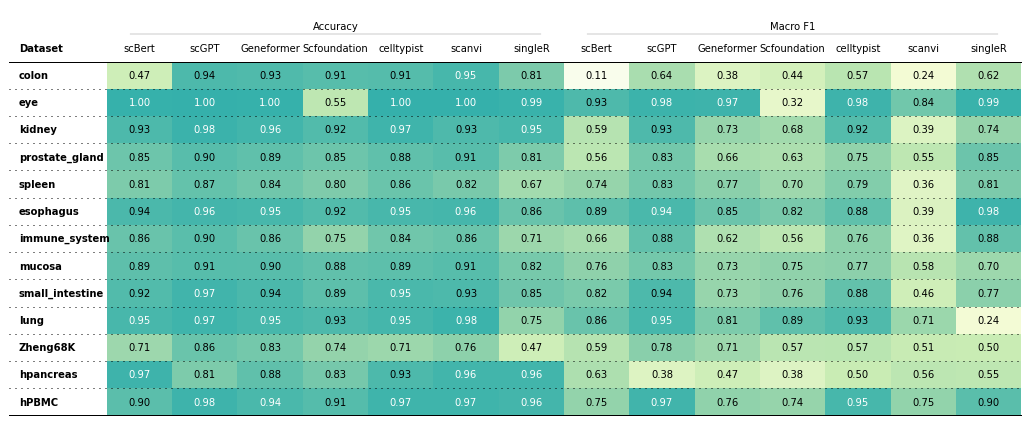

In [2]:
import pandas as pd
import os
if not os.path.exists('./fig3'):
    os.makedirs('./fig3',  exist_ok=True)

df = pd.read_excel('../plots/figs_data.xlsx', sheet_name='fig3-anno-state')

df = df.set_index("dataset")
df = df[df.columns[df.loc[_METRIC_TYPE].isin(_AGGREGATE_SCORE)]]
plot_results_table(df, save_path='./fig3/1.annotation_scores.svg')

Index(['scBert', 'scGPT', 'Geneformer', 'Scfoundation', 'scBert.1', 'scGPT.1',
       'Geneformer.1', 'Scfoundation.1'],
      dtype='object')


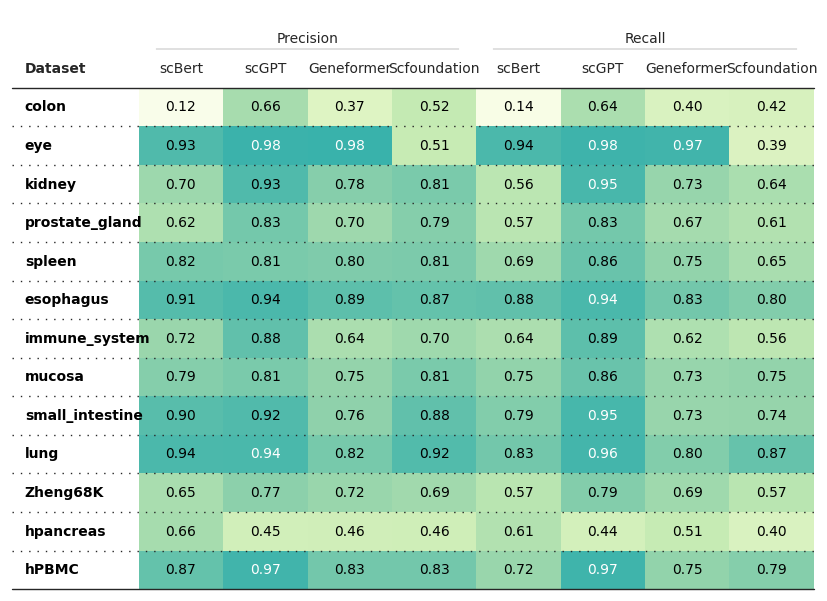

In [17]:
import pandas as pd
import os
if not os.path.exists('./fig3'):
    os.makedirs('./fig3',  exist_ok=True)

df = pd.read_excel('../plots/figs_data.xlsx', sheet_name='fig3-anno-pre-recall')

df = df.set_index("dataset")
_AGGREGATE_SCORE = ['Precision', 'Recall']
df = df[df.columns[df.loc[_METRIC_TYPE].isin(_AGGREGATE_SCORE)]]
plot_results_table(df, save_path='./fig3/2.annotation_recall_precision.svg')

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2024/8/16 15:17
# @Author  : qiuping
# @File    : scvi_llm_emb.py
# @Email: qiupinghust@163.com

"""
change log: 
    2024/8/16 15:17  create file. 
"""
import scvi
import scanpy as sc
import sys
sys.path.insert(0, "/home/share/huadjyin/home/s_huluni/project/bio_tools/CATree")
import numpy as np
import pickle
import celltypist
import scanpy as sc
import scvi
from catree.utils.utils import compute_metrics
import os
import anndata

label_keys = {
    'hpancreas_intra': 'Celltype',
    'hPBMC_intra': 'cell_type_ontology_term_id',
    'zheng68k': 'celltype',
}

adata1 = sc.read_h5ad('/home/share/huadjyin/home/s_huluni/project/bio_model_240614/Data/INT/dataset4/hPancreas.h5ad')
with open('/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/result/zero-shot/cell_emb/int/hvg3000/dataset4/scg_cell_emb.pkl', 'rb') as f:
    gpt_emb = pickle.load(f)
adata1.obs['cell_type'] = adata1.obs['celltype']


adata = anndata.AnnData(X=gpt_emb, obs=adata1.obs)
adata.var_names = [str(i) for i in range(gpt_emb.shape[1])]

adata_train = sc.read_h5ad('/home/share/huadjyin/home/s_qiuping1/workspace/omics_model/bio_model/biollm/case/data/annotation/human/organs/hpancreas_intra/train.h5ad')
adata_train = adata[adata.obs_names.isin(adata_train.obs_names.values), :].copy()

adata_test = adata[~adata.obs_names.isin(adata_train.obs_names.values), :].copy()

# adata_test.obs['cell_type'] = adata_test.obs['celltype']


/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/share/huadjyin/home/s_qiuping1/app/miniconda3/envs/scgpt/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [4]:
adata_train

AnnData object with n_obs × n_vars = 12818 × 512
    obs: 'batch', 'batchlb', 'celltype_orig', 'cellname', 'celltype', 'cell_type'

In [2]:
new_model = celltypist.train(adata_train, labels='cell_type', max_iter=30, check_expression=False)
# model_path = os.path.join("celltypist", prefix)
# if not os.path.exists(model_path):
#     os.makedirs(model_path)
# 
# new_model.write(os.path.join(model_path, f'{prefix}_celltypist_train_model.pkl'))
# print("Model saved !")


predictions = celltypist.annotate(adata_test, model=new_model)

adata_test.obsm["celltypist_emb"] = predictions.probability_matrix
adata_test.obs["celltypist_predicted_cell_type"] = predictions.predicted_labels

true_labels = adata_test.obs['cell_type']
predicted_labels = adata_test.obs['celltypist_predicted_cell_type']

eval_metrics = compute_metrics(true_labels, predicted_labels)
print("CellTypist eval, ", eval_metrics)


🍳 Preparing data before training
👀 Detected scaled expression in the input data, will try the .raw attribute
🔬 Input data has 12818 cells and 512 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 1949 cells and 512 genes
🔗 Matching reference genes in the model
🧬 512 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


CellTypist eval,  {'accuracy': 0.732683427398666, 'macro_f1': 0.3155411995478206, 'micro_f1': 0.732683427398666}


In [15]:
scvi.model.SCVI.setup_anndata(adata, batch_key=None, labels_key="cell_type")

scvi_model = scvi.model.SCVI(adata, n_latent=30, n_layers=2)

scvi_model.train(20, batch_size=90)

scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, "Unknown")

scanvi_model.train(10, batch_size=90)

SCANVI_LATENT_KEY = "scanvi_emb"
SCANVI_PREDICTIONS_KEY = "scanvi_predicted_cell_type"

adata_test.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata_test)
adata_test.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata_test)

true_labels = adata_test.obs['cell_type']
predicted_labels = adata_test.obs[SCANVI_PREDICTIONS_KEY]
eval_metrics = compute_metrics(true_labels, predicted_labels)
print("SCANVI eval, ", eval_metrics)

# eval_save_path = os.path.join("results", f"{prefix}_scanvi_eval.pkl")
# with open(eval_save_path, 'wb') as file:
#     pickle.dump(eval_metrics, file)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

ValueError: Expected parameter loc (Tensor of shape (90, 30)) of distribution Normal(loc: torch.Size([90, 30]), scale: torch.Size([90, 30])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward0>)